<a href="https://colab.research.google.com/github/cluePrints/fastai-v3-notes/blob/master/fastai3_lesson6_rossman_as_pipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip freeze | grep scipy

scipy==1.1.0


In [0]:
from fastai.basics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load

In [4]:
!ls rossmann.tgz > /dev/null || wget http://files.fast.ai/part2/lesson14/rossmann.tgz -q

ls: cannot access 'rossmann.tgz': No such file or directory


In [5]:
!ls weather.csv > /dev/null || tar zxvf rossmann.tgz

ls: cannot access 'weather.csv': No such file or directory
googletrend.csv
sample_submission.csv
state_names.csv
store.csv
store_states.csv
test.csv
train.csv
weather.csv


In [0]:
df_trends_file = pd.read_csv('googletrend.csv')
df_state_names = pd.read_csv('state_names.csv')
df_store = pd.read_csv('store.csv')
df_store_states = pd.read_csv('store_states.csv')
df_weather = pd.read_csv('weather.csv')
df_train = pd.read_csv('train.csv', low_memory=False)
df_test = pd.read_csv('test.csv')

In [0]:
# TODO: features
# Elapsed/to since promo, promo2
# Elapsed since competition open
# TODO: can I be predicting Customers in train and doing nothing about it in test? (colab learner only has 1 y_range)

In [8]:
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [0]:
def prefixed(prefix, initial_list):
  return list(map(lambda e: prefix + e, initial_list))

def sufixed(sufix, initial_list):
  return list(map(lambda e: e + sufix, initial_list))

event_columns = ['Open', 'StateHoliday', 'SchoolHoliday', 'Promo']
date_computed_category = [                 
   'is_leap_year',
   'is_month_end',
   'is_month_start',
   'is_quarter_end',
   'is_quarter_start',
   'is_year_end',
   'is_year_start',
   'weekofyear',
   'month',
   'quarter',
   'dayofweek'
]
date_computed_continuous = [                 
   'year', 'dayofyear', 'ms_since_epoch'
]
original_category = ['Store', 'StoreType', 'Open', 'Assortment',
                    'StateHoliday', 'SchoolHoliday', 'Events', 'PromoInterval', 'Promo', 'Promo2', 'State',
                    'DayOfWeek', 'CompetitionOpenSinceMonth', 'CloudCover']
original_continuous = ['state_trend', 'country_trend', 'CompetitionDistance',
                      'Promo2SinceYear', 'Promo2SinceWeek','CompetitionOpenSinceYear',
                     'Min_TemperatureC',  'Min_Sea_Level_PressurehPa',  'Min_VisibilitykM',  'Min_Humidity', 'Min_DewpointC', 
                     'Mean_TemperatureC', 'Mean_Sea_Level_PressurehPa', 'Mean_VisibilityKm', 'Mean_Humidity','Mean_Wind_SpeedKm_h','MeanDew_PointC',
                     'Max_TemperatureC',  'Max_Sea_Level_PressurehPa',  'Max_VisibilityKm',  'Max_Humidity', 'Max_Wind_SpeedKm_h', 'Dew_PointC',
                     'Precipitationmm', 'WindDirDegrees', 'Max_Gust_SpeedKm_h', ]
category_columns = (original_category
                    + prefixed('Date__', date_computed_category)
                   )
continuous_columns = (original_continuous
                    + prefixed('Date__', date_computed_continuous)
                    + sufixed('__DaysSince', event_columns)
                    + sufixed('__DaysTo', event_columns)
                     )
target_columns = ['log_sales']

used_columns = list(category_columns + target_columns + continuous_columns)
ignored_columns = list(set(df_train.columns) - set(used_columns))

def update_column_types(df):
  for col in category_columns:
    if col in df.columns:
      df[col] = df[col].astype('category')

  for col in continuous_columns + target_columns:
    if col in df.columns:
      df[col] = df[col].astype('float32')

In [0]:
def add_elapsed_for_event(df, field, prefix, grouping_field='Store', sort_field='Date'):
  day = np.timedelta64(1, 'D')
  current_store = None
  now = np.datetime64()
  last_date = now
  res = []
  for (store, value, date) in zip(df[grouping_field].values, df[field].values, df[sort_field].values):
    if (store != current_store):
      current_store = store
      last_date = now

    if (value):
      last_date = date
    
    res.append(((date - last_date)).astype('timedelta64[D]')/day)
    
  df[field + prefix] = res

def add_elapsed_event_features(df):
  df.sort_values(['Store', 'Date'], ascending=[True, False], inplace=True)
  for column in event_columns:
    add_elapsed_for_event(df, column, '__DaysTo')

  df.sort_values(['Store', 'Date'], ascending=[True, True], inplace=True)
  for column in event_columns:
    add_elapsed_for_event(df, column, '__DaysSince')

In [0]:
def generate_date_idx(df, date_column, suffix=''):
  dates = pd.to_datetime(df[date_column])
  df[suffix + 'week_number'] = dates.dt.weekofyear
  df[suffix + 'year'] = dates.dt.year
  df[date_column] = dates

def add_date_parts(df, column_name, prefix=None):
  df[column_name] = pd.to_datetime(df[column_name], unit='D')
  if prefix == None:
    prefix = column_name + '__';

  date_attributes = date_computed_continuous + date_computed_category

  for attribute in date_attributes:
    if (attribute == 'ms_since_epoch'):
      df[prefix + attribute] = df[column_name].astype('int64')      
      continue

    df[prefix + attribute] = getattr(df[column_name].dt, attribute)

  for attribute in date_computed_category:
    df[prefix + attribute] = df[prefix + attribute].astype('category')
    
  # TODO: put types in here & add to the list of features for the learner

import pdb
def _merge_no_dups(left, right, **kwargs):
  tmp = left.merge(right, **kwargs)
  dup_cols = list(filter(lambda col: ('_x' in col) or ('_y' in col), tmp.columns))
  assert len(dup_cols) == 0, str(dup_cols)
  return tmp

def _prepare_trends(df_trends_file):
  week_start = df_trends_file['week'].str.split(' ', expand=True)[0]
  week_start = pd.to_datetime(week_start)
  df_trends_file['week_start_date'] = week_start

  trends_states = df_trends_file['file'].apply(lambda s: s.split('_')[2] if s.count('_') == 2 else None)
  df_trends_file['State'] = trends_states

  df_trends_country = df_trends_file[trends_states.isna()]
  df_trends_country['country_trend'] = df_trends_country['trend']
  df_trends_country = df_trends_country.drop(['file', 'week', 'trend', 'State'], axis=1)

  df_trends = df_trends_file.loc[~trends_states.isna()]
  df_trends['state_trend'] = df_trends['trend']
  df_trends = df_trends.drop(['file', 'week', 'trend'], axis=1)
  df_trends.loc[df_trends['State'] == 'NI', 'State'] = 'HB,NI'

  Trends = namedtuple('Trends', ['country', 'by_state'])
  return Trends(country=df_trends_country, by_state=df_trends)
  
def _join_data(inputs):
  tmp = inputs.copy()
  trends = _prepare_trends(df_trends_file)

  # prepare date for joins
  generate_date_idx(tmp, 'Date')  
  generate_date_idx(trends.by_state, 'week_start_date')

  tmp = _merge_no_dups(tmp, df_store, on='Store', how='left')

  tmp = _merge_no_dups(tmp, trends.by_state, on=['State', 'year', 'week_number'], how='left', validate='many_to_one')
  tmp = _merge_no_dups(tmp, trends.country,  on=['week_start_date'], how='left', validate='many_to_one')
  tmp = _merge_no_dups(tmp, df_weather, on=['State', 'Date'], validate='many_to_many')

  return tmp

def _fill_na(inputs):
  tmp = inputs
  nas_by_column = tmp.isnull().sum()
  pct_nas_by_column = 100.0 * nas_by_column / len(inputs)
  for col in tmp.columns:
    if (nas_by_column[col] == 0):
      continue

    tmp[col].fillna(0, inplace = True)
    print(f'Imputed {pct_nas_by_column[col]}% from NAs in {col}')

  nas_by_column = tmp.isnull().sum()
  nas_by_column = nas_by_column[nas_by_column != 0]
  assert not nas_by_column.any(), "NA's found:\n " + str(nas_by_column)
  return inputs

def _log_sales(inputs):
  if not 'Sales' in inputs.columns:
    return inputs

  inputs['log_sales'] = np.log(1 + inputs['Sales'])
  inputs.drop('Sales', axis=1, inplace=True)
  return inputs

def prepare(inputs):
  inputs = _join_data(inputs)
  inputs = _fill_na(inputs)
  inputs = _log_sales(inputs)
  add_date_parts(inputs, 'Date')
  # TODO: this better to be done on train+test at once in the beginning to possibly cover more dates on the edge
  add_elapsed_event_features(inputs)
  update_column_types(inputs)
  inputs = _fill_na(inputs)
  return inputs

In [12]:
if not 'State' in df_weather.columns:
  merged = df_weather.merge(df_state_names, left_on='file', right_on='StateName', how='left')
  merged = merged.drop('StateName', axis=1)
  assert 0 == sum(merged['State'].isnull())
  merged = merged.drop('file', axis=1)
  df_weather = merged

df_weather['Date'] = pd.to_datetime(df_weather['Date'])

if not 'State' in df_store.columns:
  merged = df_store.merge(df_store_states, on='Store', how='left')
  assert 0 == sum(merged['State'].isnull())
  df_store = merged

train_features = prepare(df_train)
print('---')
test_features = prepare(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Imputed 0.25973030124586% from NAs in CompetitionDistance
Imputed 31.787764363075826% from NAs in CompetitionOpenSinceMonth
Imputed 31.787764363075826% from NAs in CompetitionOpenSinceYear
Imputed 49.94362023930186% from NAs in Promo2SinceWeek
Imputed 49.94362023930186% from NAs in Promo2SinceYear
Imputed 49.94362023930186% from NAs in PromoInterval
Imputed 2.422805932704095% from NAs in Max_VisibilityKm
Imputed 2.422805932704095% from NAs in Mean_VisibilityKm
Imputed 2.422805932704095% from NAs in Min_VisibilitykM
Imputed 76.78284403696782% from NAs in Max_Gust_SpeedKm_h
Imputed 7.896017435944826% from NAs in CloudCover
Imputed 23.81496821203902% from NAs in Events
Imputed 0.003637403916009394% from NAs in Open__DaysTo
Imputed 0.9909467965776945% from NAs in SchoolHoliday__DaysTo
Imputed 0.15532697803499576% from NAs in Open__DaysSince
Imputed 0.6575836430861308% from NAs in Promo__DaysSince
---
Imputed 0.026771806853582554% from NAs in Open
Imputed 0.2336448598130841% from NAs in Com

In [0]:
from fastai.tabular import *

In [14]:
category_columns, continuous_columns

(['Store',
  'StoreType',
  'Open',
  'Assortment',
  'StateHoliday',
  'SchoolHoliday',
  'Events',
  'PromoInterval',
  'Promo',
  'Promo2',
  'State',
  'DayOfWeek',
  'CompetitionOpenSinceMonth',
  'CloudCover',
  'Date__is_leap_year',
  'Date__is_month_end',
  'Date__is_month_start',
  'Date__is_quarter_end',
  'Date__is_quarter_start',
  'Date__is_year_end',
  'Date__is_year_start',
  'Date__weekofyear',
  'Date__month',
  'Date__quarter',
  'Date__dayofweek'],
 ['state_trend',
  'country_trend',
  'CompetitionDistance',
  'Promo2SinceYear',
  'Promo2SinceWeek',
  'CompetitionOpenSinceYear',
  'Min_TemperatureC',
  'Min_Sea_Level_PressurehPa',
  'Min_VisibilitykM',
  'Min_Humidity',
  'Min_DewpointC',
  'Mean_TemperatureC',
  'Mean_Sea_Level_PressurehPa',
  'Mean_VisibilityKm',
  'Mean_Humidity',
  'Mean_Wind_SpeedKm_h',
  'MeanDew_PointC',
  'Max_TemperatureC',
  'Max_Sea_Level_PressurehPa',
  'Max_VisibilityKm',
  'Max_Humidity',
  'Max_Wind_SpeedKm_h',
  'Dew_PointC',
  'Preci

In [0]:
def create_databunch(sample=False, verbose=False):
  def llog(a): (display(a()) if verbose else None)

  if (sample):
    sample = train_features[train_features['Date'] < pd.Timestamp('2013-03')]
    llog(lambda: (len(sample), len(train_features)))

    sample_valid_flag = sample['Date'] > pd.Timestamp('2013-02-20')
    sample_valid_idx = np.where(sample_valid_flag)
    llog(lambda: sum(sample_valid_flag))
  else:
    valid_flag = train_features['Date'] > pd.Timestamp('2015-07-10')
    len(train_features)/valid_flag.sum()
    valid_idx = np.where(valid_flag)

    sample = train_features
    sample_valid_idx = valid_idx
    

  item_list = TabularList.from_df(sample, cat_names=category_columns, cont_names=continuous_columns)
  llog(lambda: type(item_list))

  split_list = item_list.split_by_idx(sample_valid_idx)
  llog(lambda: type(split_list))

  label_list = split_list.label_from_df(cols=target_columns)
  llog(lambda: type(label_list))

  # Note to self: a lot of people (incl me) pass ordinary dataframe here and struggle. Can be improved
  label_list = label_list.add_test(TabularList.from_df(test_features, cat_names=category_columns, cont_names=continuous_columns))
  llog(lambda: type(label_list))

  data = label_list.databunch(bs=64)
  def d(): x,y = next(iter(data.train_dl)); return len(x), x[0].shape, x[1].shape, y.shape
  llog(d)

  return data

data = create_databunch(sample=False)

In [17]:
train_log_sales_min = train_features['log_sales'].min()
train_log_sales_max = train_features['log_sales'].max()
expected_log_sales_min = train_log_sales_min
expected_log_sales_max = train_log_sales_max + np.log(1.2) 
(expected_log_sales_min, expected_log_sales_max)

(0.0, 10.81702233194044)

In [0]:
learner = tabular_learner(data, layers=[1000, 100], y_range=[expected_log_sales_min, expected_log_sales_max], metrics=[exp_rmspe])

In [19]:
learner.lr_find(1e-12, 100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


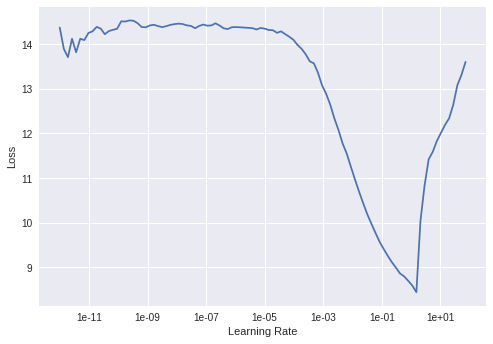

In [20]:
learner.recorder.plot(skip_end=0, skip_start=0)

In [21]:
from fastai.callbacks import SaveModelCallback
savemodel = SaveModelCallback(learner, name='p1')
learner.fit_one_cycle(3, max_lr=1e-1, callbacks=[savemodel])

epoch,train_loss,valid_loss,exp_rmspe,time
0,3.777880,3.830743,195.221268,04:37
1,3.654189,3.793288,197.506348,04:37
2,0.025833,0.089776,120.639763,04:39


Better model found at epoch 0 with val_loss value: 3.830742597579956.
Better model found at epoch 1 with val_loss value: 3.793287515640259.
Better model found at epoch 2 with val_loss value: 0.08977589011192322.


In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


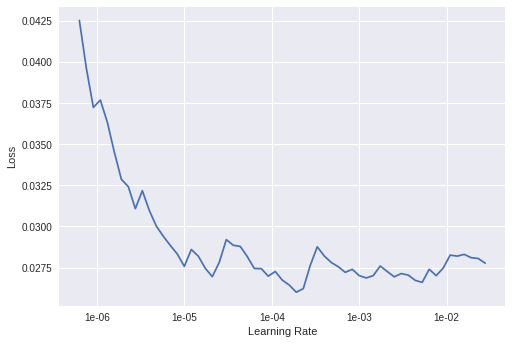

In [23]:
learner.recorder.plot()

In [24]:
savemodel = SaveModelCallback(learner, name='p2')
learner.load('p1');
learner.fit_one_cycle(5, max_lr=1e-6, callbacks=[savemodel])

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.030161,0.015718,0.128440,04:46
1,0.032155,0.020263,0.813921,04:47
2,0.031496,0.021677,17.155302,04:52
3,0.043879,0.022691,17.160471,04:45
4,0.026226,0.055405,67.296906,04:46


Better model found at epoch 0 with val_loss value: 0.015717562288045883.


In [0]:
learner.load('p2');
learner.validate()

[0.015717562, tensor(0.1284)]

In [0]:
learner.data = create_databunch(sample=False)

In [27]:
learner.lr_find(1e-12, 100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


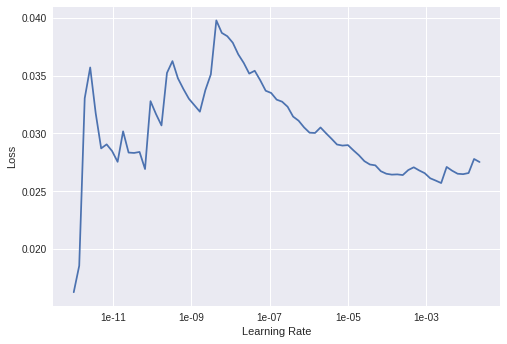

In [28]:
learner.recorder.plot(skip_start=0)

In [29]:
learner.load('p2');
savemodel = SaveModelCallback(learner, name='p3')
learner.fit_one_cycle(5, max_lr=5e-11, callbacks=[savemodel])

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.042462,0.015510,0.128458,04:45
1,0.027231,0.050539,0.123184,04:44
2,0.046406,0.044319,58.284344,04:45
3,0.027281,0.035051,29.292261,04:43
4,0.038329,0.017424,0.140535,04:43


Better model found at epoch 0 with val_loss value: 0.015509821474552155.


In [0]:
learner.load('p3')
learner.validate()

[0.0155098215, tensor(0.1285)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


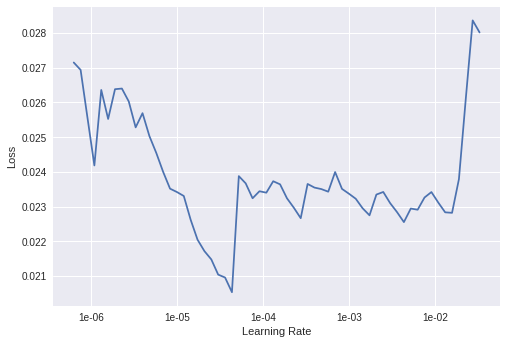

In [31]:
learner.lr_find()
learner.recorder.plot()

In [32]:
learner.load('p3')
savemodel = SaveModelCallback(learner, name='p4')
learner.fit_one_cycle(3, max_lr=1e-6, callbacks=[savemodel])

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.024680,0.038803,29.664232,04:42
1,0.025531,0.085386,108.962158,04:42
2,0.036542,0.052505,61.630772,04:55


Better model found at epoch 0 with val_loss value: 0.03880252316594124.


In [33]:
learner.load('p4')
savemodel = SaveModelCallback(learner, name='p5')
learner.fit_one_cycle(5, max_lr=1e-6, callbacks=[savemodel])

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.028121,0.014841,0.124253,04:48
1,0.026873,0.014444,0.118326,04:48
2,0.040959,0.042713,18.685106,04:53
3,0.036316,0.015995,0.264925,04:56
4,0.038765,0.017084,0.139076,04:53


Better model found at epoch 0 with val_loss value: 0.014840965159237385.
Better model found at epoch 1 with val_loss value: 0.014443598687648773.


In [34]:
losses = []
rmses = []
model_names = ['p1', 'p2', 'p3', 'p4', 'p5']
for model_name in model_names:
  learner.load(model_name)
  loss, rmse = learner.validate()
  losses += [loss]
  rmses += [rmse]
  
checkpoints = pd.DataFrame({'loss': losses, 'rmse': rmses, 'name': model_names}, columns = ['name', 'loss', 'rmse'])
checkpoints

,name,loss,rmse
0,p1,0.089776,tensor(120.6398)
1,p2,0.015718,tensor(0.1284)
2,p3,0.015510,tensor(0.1285)
3,p4,0.038803,tensor(29.6642)
4,p5,0.014444,tensor(0.1183)


In [0]:
minidx = checkpoints['loss'].idxmin()
min_name = checkpoints.iloc[minidx]['name']
learner.load(min_name);

# Predict

In [0]:
file_sufix = 'TrainSalesToo'
test_df = test_features.copy()
# TODO: can I try a TTA on this?
test_preds=learner.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]-1
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")
test_df[["Id","Sales"]].to_csv(f"rossmann_submission_{file_sufix}.csv",index=False)
from google.colab import files
files.download(f'rossmann_submission_{file_sufix}.csv')